# Second Model (`registered` and `casual` separately)

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
#plt.style.use('dark_background')
import subprocess
%config IPCompleter.use_jedi = False

validDays = 15
minLeafSamp = 15

In [2]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [3]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [4]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [5]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [6]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [7]:
df     = pd.read_csv(path/'train.csv', low_memory=False)
dfTest = pd.read_csv(path/'test.csv', low_memory=False)

In [8]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [9]:
dfTest.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

Let's save the original `datetime` column of the test set because we'll need it for when we print the submission files with the test set predictions,

In [10]:
datetimeTest = dfTest['datetime']
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

#### Handle ordinal columns (non-numeric)

There arent any...

In [11]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

The metric that they want us to use is RMSLE (root mean square log error) to do this we can convert the dependent variable `counts`/`registered`/`casual` into `log(count)` etc. and then use RMSE as our metric which is already built in.

In [12]:
depVar   = 'count'
depVar_r = 'registered'
depVar_c = 'casual'

In [13]:
df[depVar]   = np.log(df[depVar]   + 1)
df[depVar_r] = np.log(df[depVar_r] + 1)
df[depVar_c] = np.log(df[depVar_c] + 1)

The stated loss function for this competition (root mean squared log error, RMSLE) is given as:

$$
RMSLE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(t_i+1))^2 }
$$


The above cell substitutes the targets $t_i$ for $\log(t_i + 1)$. Our models will be predicting $p_i$ from RMSE,

$$
RMSE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (p_i - t_i)^2 }
$$

So to turn the predictions back into counts we just have to exponentiate and subtract 1,

$$
\begin{align}
    \log(p_i+1) &= p_i \\
    e^{\log(p_i + 1)} &= e^{p_i} \\
    p_i &= e^{p_i} - 1
\end{align}
$$

So since our model predicts $p_i$ which is equal to $\log(p_i+1)$ we don't have to worry about the $+1$ in the prediction. Our model is predicting $\log(p_i+1)$ directly because the input target is $\log(t_i+1)$, to convert our prediciton into counts we just exponentiate and subtract 1.

For the second model we'll be predicting `registered` and `casual` separately using their own dataframes respectively. Then summing those predictions to get `count`, so we'll drop `count` for now,

In [14]:
df_r = df.drop(columns=[depVar, depVar_c])
df_c = df.drop(columns=[depVar, depVar_r])
df_r.columns, df_c.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'registered'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual'],
       dtype='object'))

### Handle dates

Change the `datetime` column into a bunch of component info with `add_datepart()` and include the `time`. 

In [15]:
df     = add_datepart(df, 'datetime', time=True)
df_r   = add_datepart(df_r, 'datetime', time=True)
df_c   = add_datepart(df_c, 'datetime', time=True)
dfTest = add_datepart(dfTest, 'datetime', time=True)

In [16]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

### Using TabularPandas and TabularProc

In [17]:
df_r.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'registered', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [18]:
dfTest.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [19]:
for col in df_r.columns:
    print(col, ':', df_r[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52  49  48  37  33  28  38  36  93  29 

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [20]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 2 days of each month in the training set, i.e. 18th--19th of each month.

In [21]:
cond = (df_r.datetimeDay>=validDays)
trainIdx = np.where(~cond)[0]
validIdx = np.where( cond)[0]

splits = (list(trainIdx), list(validIdx))

In [22]:
cont,cat = cont_cat_split(df_r, max_card=18, dep_var=depVar_r)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeHour',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start',
  'datetimeMinute',
  'datetimeSecond'])

In [23]:
to_r = TabularPandas(df_r, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_r, 
                   splits=splits)

to_c = TabularPandas(df_c, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_c, 
                   splits=splits)

to = TabularPandas(df, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar, 
                   splits=splits)

toTest = TabularPandas(dfTest, 
                       procs=procs, 
                       cat_names=cat, 
                       cont_names=cont, 
                       splits=None)

In [24]:
print('registered: ', len(to_r.train), len(to_r.valid))
print('casual:     ', len(to_c.train), len(to_c.valid))
print('test:       ', len(toTest))

registered:  8026 2860
casual:      8026 2860
test:        6493


In [25]:
to_r.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeMinute,datetimeSecond,temp,atemp,humidity,windspeed,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeHour,datetimeElapsed,registered
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,81,0.0,52,1,1,0,1.293840e+09,2.639057
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80,0.0,52,1,1,1,1.293844e+09,3.496508
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80,0.0,52,1,1,2,1.293847e+09,3.332205
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75,0.0,52,1,1,3,1.293851e+09,2.397895
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75,0.0,52,1,1,4,1.293854e+09,0.693147


In [26]:
to_r.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,1,1,9.84,14.395,81,0.0,2.639057,1,1,52,1,6,1,1,2,1,2,1,2,0,1,1,1.293840e+09
1,1,1,1,1,9.02,13.635,80,0.0,3.496508,1,1,52,1,6,1,1,2,1,2,1,2,1,1,1,1.293844e+09
2,1,1,1,1,9.02,13.635,80,0.0,3.332205,1,1,52,1,6,1,1,2,1,2,1,2,2,1,1,1.293847e+09
3,1,1,1,1,9.84,14.395,75,0.0,2.397895,1,1,52,1,6,1,1,2,1,2,1,2,3,1,1,1.293851e+09
4,1,1,1,1,9.84,14.395,75,0.0,0.693147,1,1,52,1,6,1,1,2,1,2,1,2,4,1,1,1.293854e+09


In [27]:
toTest.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,2,1,10.66,11.365,56,26.002701,1,1,3,20,4,20,1,1,1,1,1,1,0,1,1,1.295482e+09
1,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,1,1,1,1.295485e+09
2,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,2,1,1,1.295489e+09
3,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,3,1,1,1.295492e+09
4,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,4,1,1,1.295496e+09


In [28]:
save_pickle(path/'to_r.pkl',to_r)
save_pickle(path/'to_c.pkl',to_c)
save_pickle(path/'toTest.pkl', toTest)

### Creating the Decision Tree

In [29]:
#to = load_pickle(path/'to.pkl') # if i want to load it in from a previous session etc.
#toTest = load_pickle(path/'toTest.pkl')

In [30]:
xs,y = to.train.xs, to.train.y

xs_r,y_r = to_r.train.xs, to_r.train.y
validXs_r,validY_r = to_r.valid.xs, to_r.valid.y

xs_c,y_c = to_c.train.xs, to_c.train.y
validXs_c,validY_c = to_c.valid.xs, to_c.valid.y

testXs = toTest.xs

In [31]:
m_r = DecisionTreeRegressor(max_leaf_nodes=4)
m_c = DecisionTreeRegressor(max_leaf_nodes=4)
m_r.fit(xs_r, y_r)
m_c.fit(xs_c, y_c)

DecisionTreeRegressor(max_leaf_nodes=4)

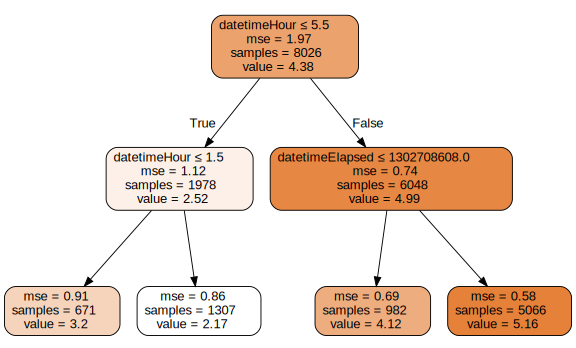

In [32]:
draw_tree(m_r, xs_r, size=8, leaves_parallel=True, precision=2)

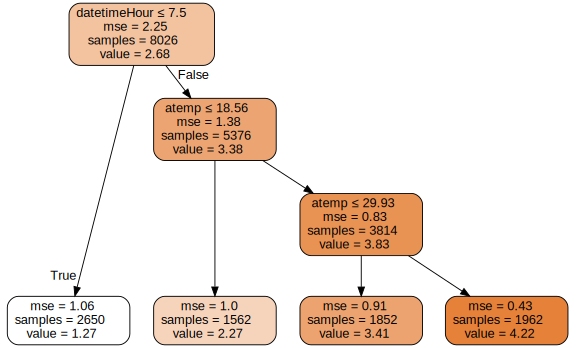

In [33]:
draw_tree(m_c, xs_c, size=8, leaves_parallel=True, precision=2)

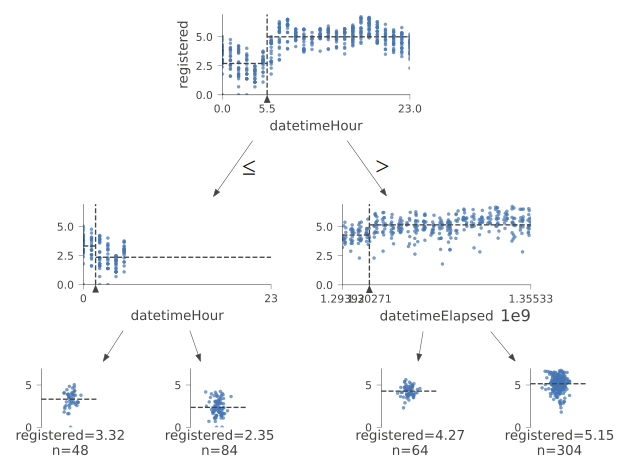

In [34]:
sampIdx = np.random.permutation(len(y_r))[:500]
dtreeviz(m_r, xs_r.iloc[sampIdx], y_r.iloc[sampIdx], xs_r.columns, depVar_r,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

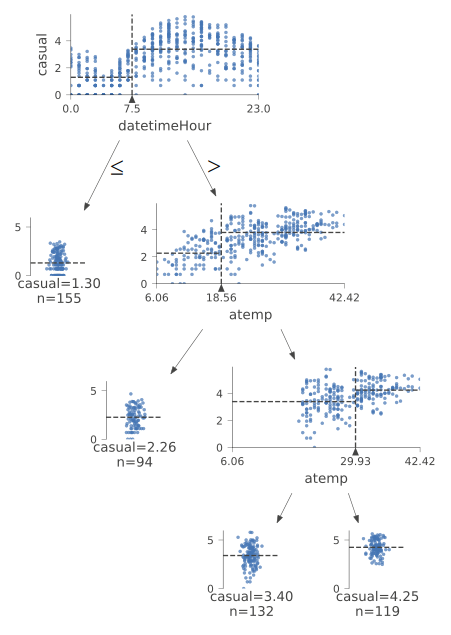

In [35]:
sampIdx = np.random.permutation(len(y_c))[:500]
dtreeviz(m_c, xs_c.iloc[sampIdx], y_c.iloc[sampIdx], xs_c.columns, depVar_c,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [36]:
m_r = DecisionTreeRegressor()
m_r.fit(xs_r, y_r)
m_c = DecisionTreeRegressor()
m_c.fit(xs_c, y_c)

DecisionTreeRegressor()

Now we'll create a function for the root mean squared error, `m_rmse`, because the competition was judged using the RMSLE (root mean squared log error) as the metric so since our counts are already the `log(counts)` using RMSE here is doing RMSLE.

In [37]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
print('registered: ', m_rmse(m_r, xs_r, y_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c))

registered:  0.0
casual:      0.0


Error is 0.0, i.e. model has perfectly fit training data because we gave it unlimited leaf nodes. Check valid to see if model is overfitting, which it obviously is,

In [39]:
print('registered: ', m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, validXs_c, validY_c))

registered:  0.442162
casual:      0.764628


So we are overfitting, because we have nearly as many leaf nodes as data points,

In [40]:
print('registered: ', m_r.get_n_leaves(), len(xs_r))
print('casual:     ', m_c.get_n_leaves(), len(xs_c))

registered:  7345 8026
casual:      6581 8026


Change stopping rule to have more data points in each leaf node,

In [41]:
m_r = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)
m_c = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)

m_r.fit(to_r.train.xs, to_r.train.y)
m_c.fit(to_c.train.xs, to_c.train.y)

print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.304209 0.370792
casual:      0.462356 0.596794


In [42]:
print('registered: ', m_r.get_n_leaves())
print('casual:     ', m_c.get_n_leaves())

registered:  413
casual:      406


### Creating a Random Forest

In [43]:
def rf(xs, y, n_estimators=400, max_samples=5_000, max_features=0.5,
       min_samples_leaf=minLeafSamp, **kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True
                                ).fit(xs, y)

In [44]:
m_r = rf(xs_r, y_r)
m_c = rf(xs_c, y_c)

In [45]:
print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.378971 0.402252
casual:      0.481371 0.559423


Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [46]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
print('registered: ', r_mse(preds_r.mean(0), validY_r)) # mean is the same as whole forest above
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])
print('casual:     ', r_mse(preds_c.mean(0), validY_c)) # mean is the same as whole forest above

registered:  0.402252
casual:      0.559423


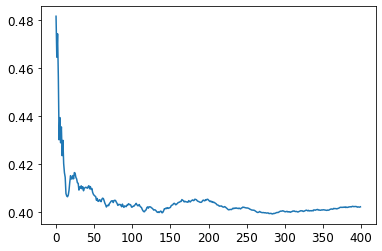

In [47]:
plt.plot([r_mse(preds_r[:i+1].mean(0), validY_r) for i in range(len(preds_r))]);

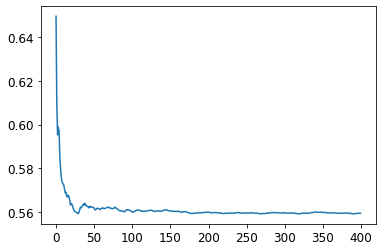

In [48]:
plt.plot([r_mse(preds_c[:i+1].mean(0), validY_c) for i in range(len(preds_c))]);

Out-of-Bag Error

In [49]:
print('train/valid registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('train/valid casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))
print('OOB         registered: ', r_mse(m_r.oob_prediction_, y_r))
print('OOB         casual:     ', r_mse(m_c.oob_prediction_, y_c))

train/valid registered:  0.378971 0.402252
train/valid casual:      0.481371 0.559423
OOB         registered:  0.409095
OOB         casual:      0.520445


OOB error being about equal to higher than validation error means that our model is generalizing slightly better to the validation set than it is to the rest of training set.

OOB error being lower than our validation error means that something else is causing that error, in addition to normal generalization error. 

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

In [50]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])

In [51]:
print('registered: ', preds_r.shape)
print('casual:     ', preds_c.shape)

registered:  (400, 2860)
casual:      (400, 2860)


In [52]:
predsSD_r = preds_r.std(0)
predsSD_c = preds_c.std(0)

In [53]:
print('registered: ', predsSD_r[:10])
print('casual:     ', predsSD_c[:10])

registered:  [0.60697304 0.64284223 0.70760911 0.51696303 0.417747   0.40470645 0.69994841 0.75945828 0.70736183 0.5939338 ]
casual:      [0.42955661 0.41970414 0.4286354  0.39178643 0.28474194 0.28697358 0.2552342  0.38201784 0.29672579 0.30022608]


Some predictions are more confident than others based on whether most trees agree or not. This can be seen by varying magnitudes of standard deviation.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [54]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [55]:
fi_r = rf_feat_importance(m_r, xs_r)
fi_r[:10]

,cols,imp
22,datetimeHour,0.743304
23,datetimeElapsed,0.063027
17,humidity,0.041399
15,temp,0.030627
2,workingday,0.027009
6,datetimeDayofweek,0.025543
16,atemp,0.023126
21,datetimeDayofyear,0.014169
4,datetimeYear,0.010582
3,weather,0.006114


In [56]:
fi_c = rf_feat_importance(m_c, xs_c)
fi_c[:10]

,cols,imp
22,datetimeHour,0.531664
15,temp,0.134560
16,atemp,0.128941
17,humidity,0.050281
2,workingday,0.036068
21,datetimeDayofyear,0.031102
6,datetimeDayofweek,0.024091
23,datetimeElapsed,0.019866
19,datetimeWeek,0.012802
3,weather,0.009444


In [57]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

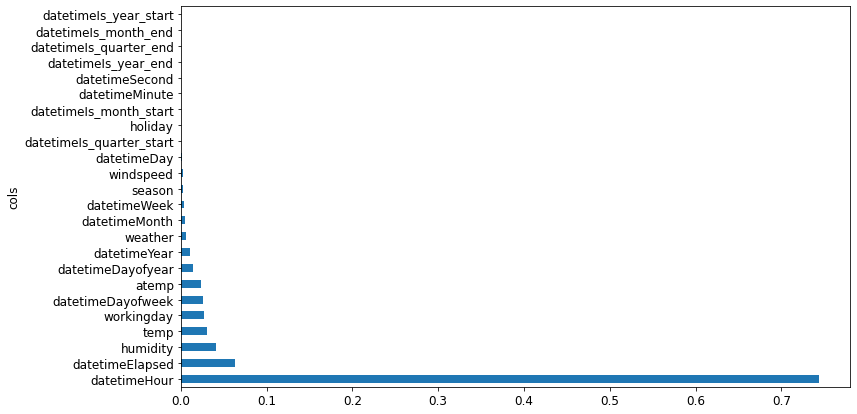

In [58]:
plot_fi(fi_r[:]);

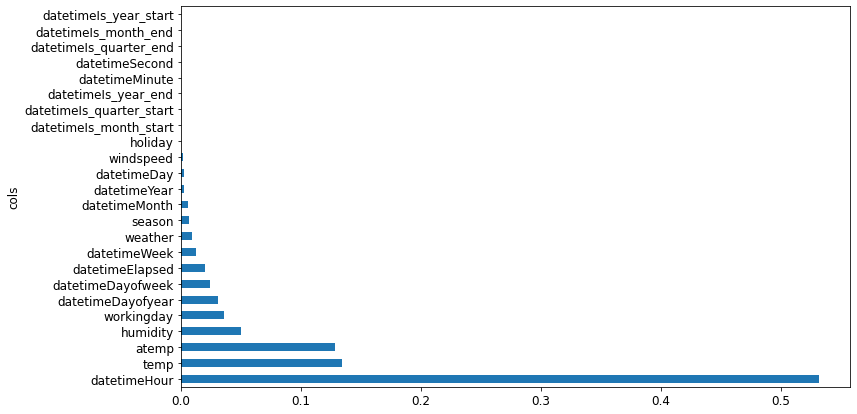

In [59]:
plot_fi(fi_c[:]);

For both `registered` and `casual` rentals `datetimeHour` was by far the most important factor which makes sense. `registered` rentals are completely dominated by the `datetimeHour` whereas `casual` rentals have a bit more spread out importance with `temp` and `atemp`.

I think it's promising to see that these two types of rentals indeed have different feature importances. I think this means that separating their predictions will be beneficial.

### Remove Low-Importance Variables

The following columns will be dropped:

In [60]:
print('registered: \n', fi_r[fi_r.imp<=0.0005].cols, sep='')
print('\n')
print('casual:     \n', fi_c[fi_c.imp<=0.0005].cols, sep='')

registered: 
10    datetimeIs_quarter_start
1                      holiday
8       datetimeIs_month_start
13              datetimeMinute
14              datetimeSecond
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
12       datetimeIs_year_start
Name: cols, dtype: object


casual:     
1                      holiday
8       datetimeIs_month_start
10    datetimeIs_quarter_start
11         datetimeIs_year_end
13              datetimeMinute
14              datetimeSecond
9       datetimeIs_quarter_end
7         datetimeIs_month_end
12       datetimeIs_year_start
Name: cols, dtype: object


The following columns will be kept:

In [61]:
toKeep_r = fi_r[fi_r.imp>0.0005].cols
toKeep_c = fi_c[fi_c.imp>0.0005].cols
print('registered: \n', toKeep_r, sep='')
print('\n')
print('casual:     \n', toKeep_c, sep='')

registered: 
22         datetimeHour
23      datetimeElapsed
17             humidity
15                 temp
2            workingday
6     datetimeDayofweek
16                atemp
21    datetimeDayofyear
4          datetimeYear
3               weather
5         datetimeMonth
19         datetimeWeek
0                season
18            windspeed
20          datetimeDay
Name: cols, dtype: object


casual:     
22         datetimeHour
15                 temp
16                atemp
17             humidity
2            workingday
21    datetimeDayofyear
6     datetimeDayofweek
23      datetimeElapsed
19         datetimeWeek
3               weather
0                season
5         datetimeMonth
4          datetimeYear
20          datetimeDay
18            windspeed
Name: cols, dtype: object


I think I need to make two different test sets here because the important variables are different and I need to drop different columns for the two different predictions,

In [62]:
xsImp_r = xs_r[toKeep_r]
xsImp_c = xs_c[toKeep_c]

validXsImp_r = validXs_r[toKeep_r]
validXsImp_c = validXs_c[toKeep_c]

testXsImp_r = testXs[toKeep_r]
testXsImp_c = testXs[toKeep_c]

In [63]:
print(xsImp_r.columns == validXsImp_r.columns)
print(xsImp_r.columns == testXsImp_r.columns)

print(xsImp_c.columns == validXsImp_c.columns)
print(xsImp_c.columns == testXsImp_c.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


All columns for training, validation, and testing are the same for `registered` and `casual` respectively.

In [64]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

In [65]:
print('Error after importance filtering:')
print('registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

Error after importance filtering:
registered:  0.388157 0.413412
casual:      0.485095 0.563138


Our accuracy is about the same, even a bit better, and now our model is simpler to train.

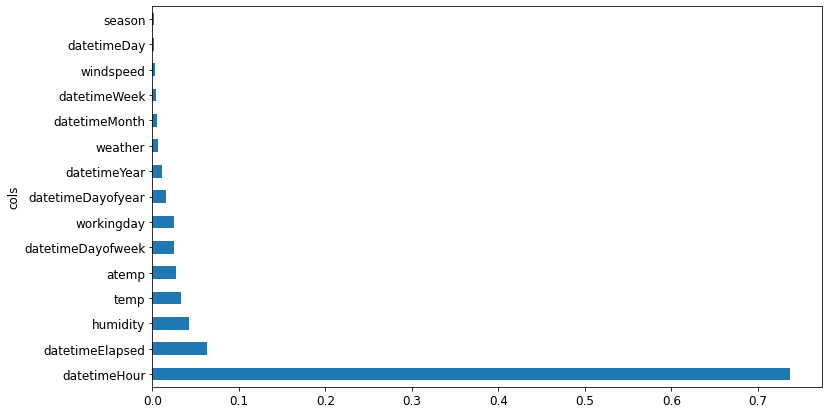

In [66]:
plot_fi(rf_feat_importance(m_r, xsImp_r));

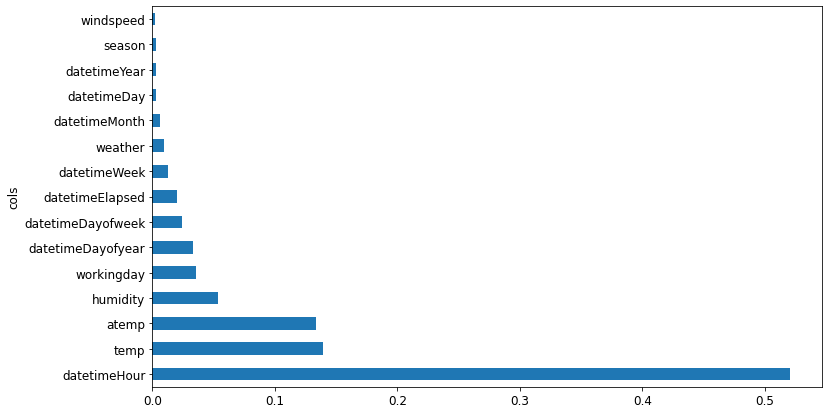

In [67]:
plot_fi(rf_feat_importance(m_c, xsImp_c));

### Remove Redundant Features

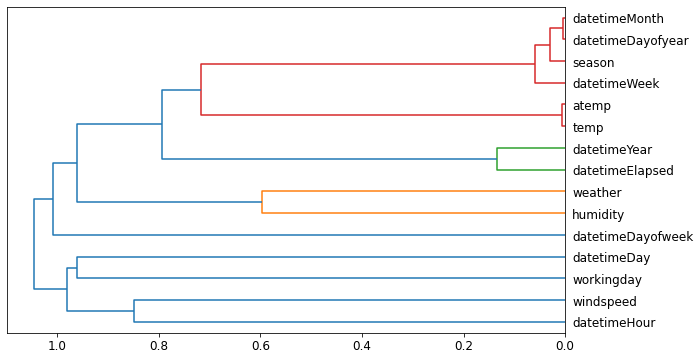

In [68]:
cluster_columns(xsImp_r)

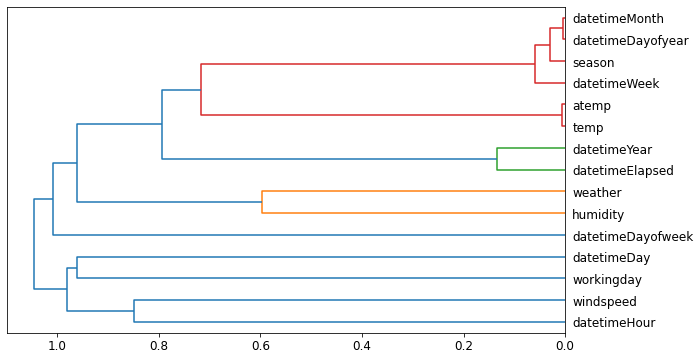

In [69]:
cluster_columns(xsImp_c)

We could try removing `datetimeMonth / datetimeDayofyear` and `temp / atemp`,

In [70]:
def get_oob(df, y):
    #m = RandomForestRegressor(n_estimators=80, min_samples_leaf=15, max_samples=None,
    #                          max_features=0.5, n_jobs=-1, oob_score=True)
    #m.fit(df, y)
    m = rf(df, y, max_samples=None)
    
    return m.oob_score_

In [71]:
print('Baseline OOB scores')
print('registered: ', get_oob(xsImp_r, y_r))
print('casual:     ', get_oob(xsImp_c, y_c))

Baseline OOB scores
registered:  0.9223035460710748
casual:      0.8843659169432396


In [72]:
print('registered:')
{c:get_oob(xsImp_r.drop(c, axis=1), y_r) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

registered:


{'temp': 0.927543433144433,
 'atemp': 0.925973369901784,
 'datetimeMonth': 0.9269543634606499,
 'datetimeDayofyear': 0.9268011584914091}

The OOB score is potentially slightly higher when dropping `atemp` or `datetimeDayofyear` but those changes are so small that rerunning sometimes makes them lower.

In [73]:
toDrop_r = []

In [74]:
print('casual:')
{c:get_oob(xsImp_c.drop(c, axis=1), y_c) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

casual:


{'temp': 0.8864007718333091,
 'atemp': 0.8873357695885304,
 'datetimeMonth': 0.8860038054294338,
 'datetimeDayofyear': 0.8843682287037781}

The OOB score for dropping `atemp` from `casual` is consistently about three thousandths higher than the original OOB score.

In [75]:
toDrop_c = ['atemp']

In [76]:
print('registered: \n', xsImp_r.columns, sep='')
print('\n')
print('casual:     \n', xsImp_c.columns, sep='')

registered: 
Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'temp', 'workingday',
       'datetimeDayofweek', 'atemp', 'datetimeDayofyear', 'datetimeYear',
       'weather', 'datetimeMonth', 'datetimeWeek', 'season', 'windspeed',
       'datetimeDay'],
      dtype='object')


casual:     
Index(['datetimeHour', 'temp', 'atemp', 'humidity', 'workingday',
       'datetimeDayofyear', 'datetimeDayofweek', 'datetimeElapsed',
       'datetimeWeek', 'weather', 'season', 'datetimeMonth', 'datetimeYear',
       'datetimeDay', 'windspeed'],
      dtype='object')


In [77]:
print('registered: ', get_oob(xsImp_r.drop(toDrop_r, axis=1), y_r))
print('casual:     ', get_oob(xsImp_c.drop(toDrop_c, axis=1), y_c))

registered:  0.9216683474331254
casual:      0.8865926977854854


Dropping `datetimeMonth` gives a little higher OOB score for `registered` and dropping nothing keeps `casual` the same.

In [78]:
xsFinal_r = xsImp_r.drop(toDrop_r, axis=1)
xsFinal_c = xsImp_c.drop(toDrop_c, axis=1)

validXsFinal_r = validXsImp_r.drop(toDrop_r, axis=1)
validXsFinal_c = validXsImp_c.drop(toDrop_c, axis=1)

testXsFinal_r = testXsImp_r.drop(toDrop_r, axis=1)
testXsFinal_c = testXsImp_c.drop(toDrop_c, axis=1)

xsFinal_r.columns, validXsFinal_r.columns

(Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'temp', 'workingday',
        'datetimeDayofweek', 'atemp', 'datetimeDayofyear', 'datetimeYear',
        'weather', 'datetimeMonth', 'datetimeWeek', 'season', 'windspeed',
        'datetimeDay'],
       dtype='object'),
 Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'temp', 'workingday',
        'datetimeDayofweek', 'atemp', 'datetimeDayofyear', 'datetimeYear',
        'weather', 'datetimeMonth', 'datetimeWeek', 'season', 'windspeed',
        'datetimeDay'],
       dtype='object'))

In [79]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

print('Before registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('Before casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('After registered:  ', m_rmse(m_r, xsFinal_r, y_r), m_rmse(m_r, validXsFinal_r, validY_r))
print('After casual:      ', m_rmse(m_c, xsFinal_c, y_c), m_rmse(m_c, validXsFinal_c, validY_c))

Before registered:  0.394826 0.419795
Before casual:      0.484434 0.562732
After registered:   0.384947 0.409501
After casual:       0.480382 0.556535


Valid error is a little less for `registered` than it was before redundant feature removal which makes sense because we didn't remove anything from the `casual` dataset.

### Partial Dependence

In [80]:
to_c.classes['season']

['#na#', 1, 2, 3, 4]

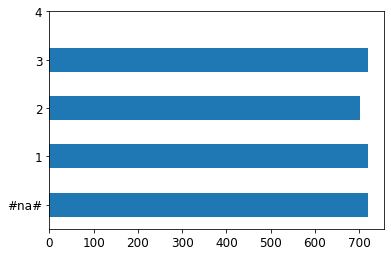

In [81]:
# all remaining variables are continuous so a bar plot doesn't really apply.
p = validXs_r['season'].value_counts(sort=False).plot.barh()
c = to_r.classes['season']
plt.yticks(ticks=range(len(c)), labels=c);

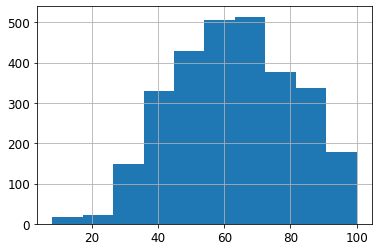

In [82]:
ax = validXsFinal_r['humidity'].hist()

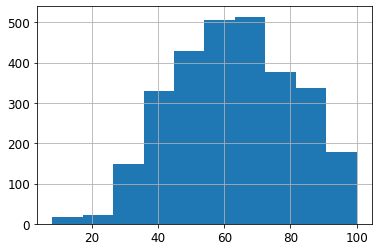

In [83]:
ax = validXsFinal_c['humidity'].hist()

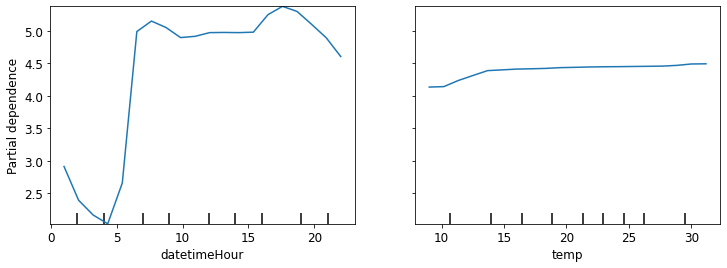

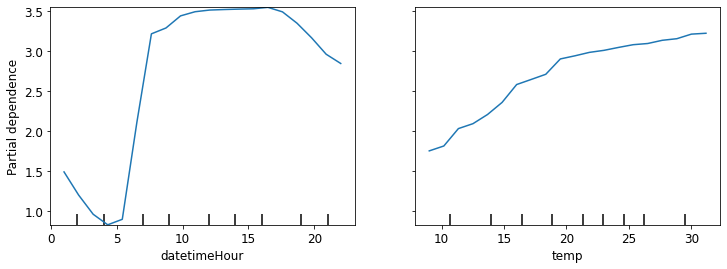

In [84]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_r, validXsFinal_r,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_c, validXsFinal_c,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

The ordinate (counts) is log-scale so a linear dependence is actually an exponential dependence.

### Tree Interpreter

In [85]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [86]:
row_r = validXsFinal_r.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_r, row_r.values)

In [87]:
prediction[0], bias[0], contributions[0].sum()

(array([2.83041589]), 4.382358489487705, -1.5519425964897435)

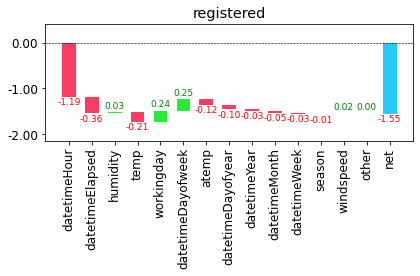

In [88]:
waterfall(validXsFinal_r.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='registered');

In [89]:
row_c = validXsFinal_c.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_c, row_c.values)

In [90]:
prediction[0], bias[0], contributions[0].sum()

(array([0.75919894]), 2.682934165432335, -1.9237352245761545)

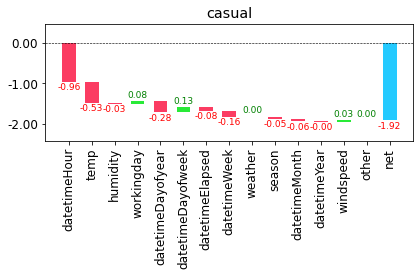

In [91]:
waterfall(validXsFinal_c.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='casual');

This information answers the question: "for predicting a particular row of data, what were the most important factors and how did they influence the prediction?"

For some of these categories the signs are flipped between `registered` and `casual`. I'm not entirely sure what that means but I'd guess that these categores have an inverse impact on count between the two types of counts which is interesting.

## Extrapolation and Neural Networks

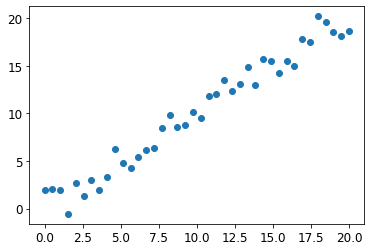

In [92]:
xLin = torch.linspace(0, 20, steps=40)
yLin = xLin + torch.randn_like(xLin)
plt.scatter(xLin, yLin);

In [93]:
xsLin = xLin[:,None]
xsLin.shape

torch.Size([40, 1])

In [94]:
mLin = RandomForestRegressor().fit(xsLin[:30], yLin[:30])

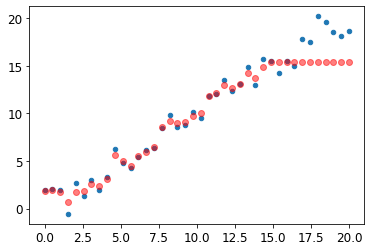

In [95]:
plt.scatter(xLin, yLin, 20)
plt.scatter(xLin, mLin.predict(xsLin), color='red', alpha=0.5);

### Finding Out-of-Domain Data

Concatenate training and validation data and label them with 0 for training and 1 for valid, then calculate importance of each column for predicting valid or not.

In [96]:
dfDom_r = pd.concat([xsFinal_r, validXsFinal_r])
isValid_r = np.array([0]*len(xsFinal_r) + [1]*len(validXsFinal_r))

dfDom_c = pd.concat([xsFinal_c, validXsFinal_c])
isValid_c = np.array([0]*len(xsFinal_c) + [1]*len(validXsFinal_c))

In [97]:
m_r = rf(dfDom_r, isValid_r)
rf_feat_importance(m_r, dfDom_r)

,cols,imp
14,datetimeDay,9.623751e-01
7,datetimeDayofyear,2.407881e-02
1,datetimeElapsed,5.820608e-03
11,datetimeWeek,4.092170e-03
10,datetimeMonth,1.946014e-03
3,temp,1.010027e-03
6,atemp,4.535240e-04
2,humidity,6.319528e-05
12,season,4.596319e-05
5,datetimeDayofweek,4.084738e-05


In [98]:
m_c = rf(dfDom_c, isValid_c)
rf_feat_importance(m_c, dfDom_c)

,cols,imp
12,datetimeDay,0.964514
4,datetimeDayofyear,0.021388
6,datetimeElapsed,0.006131
7,datetimeWeek,0.005197
10,datetimeMonth,0.001527
1,temp,0.000959
2,humidity,0.000146
9,season,0.000052
11,datetimeYear,0.000047
13,windspeed,0.000026


These are the scores of how important each column is in determining if a given row is in the validation set or the training set.

`datetimeDay` makes sense because the validation set days are at the end of the month, i.e. 16-20 based on how I set it earlier. 

`datetimeDayofyear` makes some sense for the same reason though since it ranges from 1-354 it doesn't have the same level of predictive power for valid vs. training because the numbers don't repeat as explicitly as `datetimeDay` does.

In [99]:
print('registered:')
tuple(dfDom_r.columns)

registered:


('datetimeHour',
 'datetimeElapsed',
 'humidity',
 'temp',
 'workingday',
 'datetimeDayofweek',
 'atemp',
 'datetimeDayofyear',
 'datetimeYear',
 'weather',
 'datetimeMonth',
 'datetimeWeek',
 'season',
 'windspeed',
 'datetimeDay')

In [100]:
print('casual:')
tuple(dfDom_c.columns)

casual:


('datetimeHour',
 'temp',
 'humidity',
 'workingday',
 'datetimeDayofyear',
 'datetimeDayofweek',
 'datetimeElapsed',
 'datetimeWeek',
 'weather',
 'season',
 'datetimeMonth',
 'datetimeYear',
 'datetimeDay',
 'windspeed')

In [101]:
m_r = rf(xsFinal_r, y_r)
print('registered orig:', m_rmse(m_r, validXsFinal_r, validY_r))

categories = tuple(dfDom_r.columns)

for c in categories:
    m_r = rf(xsFinal_r.drop(c, axis=1), y_r)
    print(c, m_rmse(m_r, validXsFinal_r.drop(c, axis=1), validY_r))

registered orig: 0.413509
datetimeHour 1.188356
datetimeElapsed 0.413501
humidity 0.399035
temp 0.403175
workingday 0.422633
datetimeDayofweek 0.427029
atemp 0.402007
datetimeDayofyear 0.398889
datetimeYear 0.39686
weather 0.40673
datetimeMonth 0.401647
datetimeWeek 0.40047
season 0.401023
windspeed 0.397701
datetimeDay 0.396981


The error is not lowered from the original value of 0.398487 by dropping any of the columns.

In [102]:
# toDrop_r = []

# xsFinal_r = xsFinal_r.drop(columns=toDrop_r)
# validXsFinal_r = validXsFinal_r.drop(columns=toDrop_r)
# testXsFinal_r = testXsFinal_r.drop(columns=toDrop_r)

In [103]:
m_c = rf(xsFinal_c, y_c)
print('casual orig:', m_rmse(m_c, validXsFinal_c, validY_c))

categories = tuple(dfDom_c.columns)

for c in categories:
    m_c = rf(xsFinal_c.drop(c, axis=1), y_c)
    print(c, m_rmse(m_c, validXsFinal_c.drop(c, axis=1), validY_c))

casual orig: 0.554919
datetimeHour 1.049732
temp 0.61245
humidity 0.569354
workingday 0.558697
datetimeDayofyear 0.561789
datetimeDayofweek 0.56901
datetimeElapsed 0.562914
datetimeWeek 0.560569
weather 0.565231
season 0.557979
datetimeMonth 0.558339
datetimeYear 0.557813
datetimeDay 0.555442
windspeed 0.558986


From the original RMSLE of 0.555341 it get's worse if we drop any columns.

In [104]:
# toDrop = []

# xsFinal = xsFinal.drop(columns=toDrop)
# validXsFinal = validXsFinal.drop(columns=toDrop)
# testXsFinal = testXsFinal.drop(columns=toDrop)

# print(xsFinal.columns == validXsFinal.columns, xsFinal.columns == testXsFinal.columns)
# xsFinal.columns, validXsFinal.columns, testXsFinal.columns

Remake the model now that we've dropped columns,

In [105]:
m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.414192
casual final: 0.554685


Now predict the test set with only the random forest,

In [106]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest_r, rfPredsTest_c

(array([2.07878516, 1.80694715, 1.39814763, ..., 5.08759913, 4.74623241, 4.62723394]),
 array([0.61455818, 0.51591823, 0.44511866, ..., 1.99167606, 1.93659973, 1.88827484]))

## Using a Neural Network

In [107]:
dfNN = pd.read_csv(path/'train.csv', low_memory=False)

dfNN[depVar]   = np.log(dfNN[depVar]   + 1)
dfNN[depVar_r] = np.log(dfNN[depVar_r] + 1)
dfNN[depVar_c] = np.log(dfNN[depVar_c] + 1)

dfNN = add_datepart(dfNN, 'datetime', time=True)

In [108]:
dfNNTest = pd.read_csv(path/'test.csv', low_memory=False)
dfNNTest = add_datepart(dfNNTest, 'datetime', time=True)

In [109]:
' '.join(o for o in dfNN.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

We can use the work we did with the RF to trim unwanted columns for the NN. Here are the columns we kept for the RF,

In [110]:
print('registered:', xsFinal_r.columns, len(xsFinal_r.columns))
print('casual:    ', xsFinal_c.columns, len(xsFinal_c.columns))

registered: Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'temp', 'workingday',
       'datetimeDayofweek', 'atemp', 'datetimeDayofyear', 'datetimeYear',
       'weather', 'datetimeMonth', 'datetimeWeek', 'season', 'windspeed',
       'datetimeDay'],
      dtype='object') 15
casual:     Index(['datetimeHour', 'temp', 'humidity', 'workingday', 'datetimeDayofyear',
       'datetimeDayofweek', 'datetimeElapsed', 'datetimeWeek', 'weather',
       'season', 'datetimeMonth', 'datetimeYear', 'datetimeDay', 'windspeed'],
      dtype='object') 14


In [111]:
combined = pd.concat([dfNN, dfNNTest])
dfNNFinal_r = combined[list(xsFinal_r.columns) + [depVar_r]]
dfNNFinal_r

,datetimeHour,datetimeElapsed,humidity,temp,workingday,datetimeDayofweek,atemp,datetimeDayofyear,datetimeYear,weather,datetimeMonth,datetimeWeek,season,windspeed,datetimeDay,registered
0,0,1.293840e+09,81,9.84,0,5,14.395,1,2011,1,1,52,1,0.0000,1,2.639057
1,1,1.293844e+09,80,9.02,0,5,13.635,1,2011,1,1,52,1,0.0000,1,3.496508
2,2,1.293847e+09,80,9.02,0,5,13.635,1,2011,1,1,52,1,0.0000,1,3.332205
3,3,1.293851e+09,75,9.84,0,5,14.395,1,2011,1,1,52,1,0.0000,1,2.397895
4,4,1.293854e+09,75,9.84,0,5,14.395,1,2011,1,1,52,1,0.0000,1,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,1.356980e+09,60,10.66,1,0,12.880,366,2012,2,12,1,1,11.0014,31,NaN
6489,20,1.356984e+09,60,10.66,1,0,12.880,366,2012,2,12,1,1,11.0014,31,NaN
6490,21,1.356988e+09,60,10.66,1,0,12.880,366,2012,1,12,1,1,11.0014,31,NaN
6491,22,1.356991e+09,56,10.66,1,0,13.635,366,2012,1,12,1,1,8.9981,31,NaN


In [112]:
#dfNNFinal_r = dfNN[list(xsFinal_r.columns) + [depVar_r]]
#dfNNFinal_r

In [113]:
dfNNFinal_c = combined[list(xsFinal_c.columns) + [depVar_c]]
dfNNFinal_c

,datetimeHour,temp,humidity,workingday,datetimeDayofyear,datetimeDayofweek,datetimeElapsed,datetimeWeek,weather,season,datetimeMonth,datetimeYear,datetimeDay,windspeed,casual
0,0,9.84,81,0,1,5,1.293840e+09,52,1,1,1,2011,1,0.0000,1.386294
1,1,9.02,80,0,1,5,1.293844e+09,52,1,1,1,2011,1,0.0000,2.197225
2,2,9.02,80,0,1,5,1.293847e+09,52,1,1,1,2011,1,0.0000,1.791759
3,3,9.84,75,0,1,5,1.293851e+09,52,1,1,1,2011,1,0.0000,1.386294
4,4,9.84,75,0,1,5,1.293854e+09,52,1,1,1,2011,1,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,10.66,60,1,366,0,1.356980e+09,1,2,1,12,2012,31,11.0014,NaN
6489,20,10.66,60,1,366,0,1.356984e+09,1,2,1,12,2012,31,11.0014,NaN
6490,21,10.66,60,1,366,0,1.356988e+09,1,1,1,12,2012,31,11.0014,NaN
6491,22,10.66,56,1,366,0,1.356991e+09,1,1,1,12,2012,31,8.9981,NaN


In [114]:
#dfNNFinal_c = dfNN[list(xsFinal_c.columns) + [depVar_c]]
#dfNNFinal_c

In [115]:
#dfNNFinalTest_r = dfNNTest[list(xsFinal_r.columns)]
#dfNNFinalTest_r

In [116]:
#dfNNFinalTest_c = dfNNTest[list(xsFinal_c.columns)]
#dfNNFinalTest_c

##### `registered`

In [117]:
contNN_r,catNN_r = cont_cat_split(dfNNFinal_r, max_card=18, dep_var=depVar_r)

In [118]:
dfNNFinal_r[catNN_r].nunique()

workingday            2
datetimeDayofweek     7
datetimeYear          2
weather               4
datetimeMonth        12
season                4
dtype: int64

In [119]:
dfNNFinal_r[contNN_r].nunique()

datetimeHour            24
datetimeElapsed      17379
humidity                89
temp                    50
atemp                   65
datetimeDayofyear      366
datetimeWeek            52
windspeed               30
datetimeDay             31
dtype: int64

It seems to me that some of these variables although somewhat lower in cardinality are continuous in nature.

Specifically, `datetimeDayofyear` and `datetimeWeek` are categorical in nature, though since the predicting on the test set gives errors for out of domain categorical variables let's keep `datetimeDayofyear`, `datetimeWeek`, and `datetimeDay` as `cont` variables.

In [120]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_r.remove(i)
    catNN_r.append(i)
    
print('catNN:', catNN_r)
print('contNN:', contNN_r)

catNN: ['workingday', 'datetimeDayofweek', 'datetimeYear', 'weather', 'datetimeMonth', 'season', 'datetimeHour']
contNN: ['datetimeElapsed', 'humidity', 'temp', 'atemp', 'datetimeDayofyear', 'datetimeWeek', 'windspeed', 'datetimeDay']


##### `casual`

In [121]:
contNN_c,catNN_c = cont_cat_split(dfNNFinal_c, max_card=18, dep_var=depVar_c)

In [122]:
dfNNFinal_c[catNN_c].nunique()

workingday            2
datetimeDayofweek     7
weather               4
season                4
datetimeMonth        12
datetimeYear          2
dtype: int64

In [123]:
dfNNFinal_c[contNN_c].nunique()

datetimeHour            24
temp                    50
humidity                89
datetimeDayofyear      366
datetimeElapsed      17379
datetimeWeek            52
datetimeDay             31
windspeed               30
dtype: int64

In [124]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_c.remove(i)
    catNN_c.append(i)
    
print('catNN:', catNN_c)
print('contNN:', contNN_c)

catNN: ['workingday', 'datetimeDayofweek', 'weather', 'season', 'datetimeMonth', 'datetimeYear', 'datetimeHour']
contNN: ['temp', 'humidity', 'datetimeDayofyear', 'datetimeElapsed', 'datetimeWeek', 'datetimeDay', 'windspeed']


Testing dataframes don't need to be checked because we altered the lists of columns themselves.

Create `TabularPandas` object in the same was as before but with `Normalize` since we're using it for an NN.

In [125]:
procsNN = [Categorify, FillMissing, Normalize]
toNN_r = TabularPandas(dfNNFinal_r,
                       procs=procs,
                       cat_names=catNN_r,
                       cont_names=contNN_r,
                       y_names=depVar_r,
                       splits=splits)

toNN_c = TabularPandas(dfNNFinal_c,
                       procs=procs,
                       cat_names=catNN_c,
                       cont_names=contNN_c,
                       y_names=depVar_c,
                       splits=splits)

#toNNtest_r = TabularPandas(dfNNFinalTest_r,
#                           procs=procs,
#                           cat_names=catNN_r,
#                           cont_names=contNN_r,
#                           splits=None)

#toNNtest_c = TabularPandas(dfNNFinalTest_c,
#                           procs=procs,
#                           cat_names=catNN_c,
#                           cont_names=contNN_c,
#                           splits=None)

In [126]:
toNN_r.show()

,workingday,datetimeDayofweek,datetimeYear,weather,datetimeMonth,season,datetimeHour,datetimeElapsed,humidity,temp,atemp,datetimeDayofyear,datetimeWeek,windspeed,datetimeDay,registered
0,0,5,2011,1,1,1,0,1.293840e+09,81,9.84,14.395000,1,52,0.0000,1,2.639057
1,0,5,2011,1,1,1,1,1.293844e+09,80,9.02,13.635000,1,52,0.0000,1,3.496508
2,0,5,2011,1,1,1,2,1.293847e+09,80,9.02,13.635000,1,52,0.0000,1,3.332205
3,0,5,2011,1,1,1,3,1.293851e+09,75,9.84,14.395000,1,52,0.0000,1,2.397895
4,0,5,2011,1,1,1,4,1.293854e+09,75,9.84,14.395000,1,52,0.0000,1,0.693147
5,0,5,2011,2,1,1,5,1.293858e+09,75,9.84,12.880000,1,52,6.0032,1,0.693147
6,0,5,2011,1,1,1,6,1.293862e+09,80,9.02,13.635000,1,52,0.0000,1,0.000000
7,0,5,2011,1,1,1,7,1.293865e+09,86,8.20,12.880000,1,52,0.0000,1,1.098612
8,0,5,2011,1,1,1,8,1.293869e+09,75,9.84,14.395000,1,52,0.0000,1,2.079442
9,0,5,2011,1,1,1,9,1.293872e+09,76,13.12,17.424999,1,52,0.0000,1,1.945910


Tabular models don't generally need much GPU ram so we can have bigger batch sizes,

I think creating the `TabularPandas` objects with dataframes that have both training and test data will initialize the NN such that the range of categories that are unique to the test set will not cause errors down the line.

In [127]:
toTrainNN_r = TabularPandas(dfNNFinal_r[:len(dfNN)],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                            splits=splits
                           )
toTrainNN_r.show()

toTestNN_r = TabularPandas(dfNNFinal_r[len(dfNN):],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                           )
toTestNN_r.show()

,workingday,datetimeDayofweek,datetimeYear,weather,datetimeMonth,season,datetimeHour,datetimeElapsed,humidity,temp,atemp,datetimeDayofyear,datetimeWeek,windspeed,datetimeDay,registered
0,0,5,2011,1,1,1,0,1.293840e+09,81,9.84,14.395000,1,52,0.0000,1,2.639057
1,0,5,2011,1,1,1,1,1.293844e+09,80,9.02,13.635000,1,52,0.0000,1,3.496508
2,0,5,2011,1,1,1,2,1.293847e+09,80,9.02,13.635000,1,52,0.0000,1,3.332205
3,0,5,2011,1,1,1,3,1.293851e+09,75,9.84,14.395000,1,52,0.0000,1,2.397895
4,0,5,2011,1,1,1,4,1.293854e+09,75,9.84,14.395000,1,52,0.0000,1,0.693147
5,0,5,2011,2,1,1,5,1.293858e+09,75,9.84,12.880000,1,52,6.0032,1,0.693147
6,0,5,2011,1,1,1,6,1.293862e+09,80,9.02,13.635000,1,52,0.0000,1,0.000000
7,0,5,2011,1,1,1,7,1.293865e+09,86,8.20,12.880000,1,52,0.0000,1,1.098612
8,0,5,2011,1,1,1,8,1.293869e+09,75,9.84,14.395000,1,52,0.0000,1,2.079442
9,0,5,2011,1,1,1,9,1.293872e+09,76,13.12,17.424999,1,52,0.0000,1,1.945910


,workingday,datetimeDayofweek,datetimeYear,weather,datetimeMonth,season,datetimeHour,datetimeElapsed,humidity,temp,atemp,datetimeDayofyear,datetimeWeek,windspeed,datetimeDay,registered
0,1,3,2011,1,1,1,0,1.295482e+09,56,10.66,11.365,20,3,26.002701,20,NaN
1,1,3,2011,1,1,1,1,1.295485e+09,56,10.66,13.635,20,3,0.000000,20,NaN
2,1,3,2011,1,1,1,2,1.295489e+09,56,10.66,13.635,20,3,0.000000,20,NaN
3,1,3,2011,1,1,1,3,1.295492e+09,56,10.66,12.880,20,3,11.001400,20,NaN
4,1,3,2011,1,1,1,4,1.295496e+09,56,10.66,12.880,20,3,11.001400,20,NaN
5,1,3,2011,1,1,1,5,1.295500e+09,60,9.84,11.365,20,3,15.001300,20,NaN
6,1,3,2011,1,1,1,6,1.295503e+09,60,9.02,10.605,20,3,15.001300,20,NaN
7,1,3,2011,1,1,1,7,1.295507e+09,55,9.02,10.605,20,3,15.001300,20,NaN
8,1,3,2011,1,1,1,8,1.295510e+09,55,9.02,10.605,20,3,19.001200,20,NaN
9,1,3,2011,2,1,1,9,1.295514e+09,52,9.84,11.365,20,3,15.001300,20,NaN


In [128]:
toTrainNN_c = TabularPandas(dfNNFinal_c[:len(dfNN)],
                            procs=procs,
                            cat_names=catNN_c,
                            cont_names=contNN_c,
                            y_names=depVar_c,
                            splits=splits
                           )
toTrainNN_c.show()

toTestNN_c = TabularPandas(dfNNFinal_c[len(dfNN):],
                           procs=procs,
                           cat_names=catNN_c,
                           cont_names=contNN_c,
                           y_names=depVar_c,
                          )
toTestNN_c.show()

,workingday,datetimeDayofweek,weather,season,datetimeMonth,datetimeYear,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,datetimeDay,windspeed,casual
0,0,5,1,1,1,2011,0,9.84,81,1,1.293840e+09,52,1,0.0000,1.386294
1,0,5,1,1,1,2011,1,9.02,80,1,1.293844e+09,52,1,0.0000,2.197225
2,0,5,1,1,1,2011,2,9.02,80,1,1.293847e+09,52,1,0.0000,1.791759
3,0,5,1,1,1,2011,3,9.84,75,1,1.293851e+09,52,1,0.0000,1.386294
4,0,5,1,1,1,2011,4,9.84,75,1,1.293854e+09,52,1,0.0000,0.000000
5,0,5,2,1,1,2011,5,9.84,75,1,1.293858e+09,52,1,6.0032,0.000000
6,0,5,1,1,1,2011,6,9.02,80,1,1.293862e+09,52,1,0.0000,1.098612
7,0,5,1,1,1,2011,7,8.20,86,1,1.293865e+09,52,1,0.0000,0.693147
8,0,5,1,1,1,2011,8,9.84,75,1,1.293869e+09,52,1,0.0000,0.693147
9,0,5,1,1,1,2011,9,13.12,76,1,1.293872e+09,52,1,0.0000,2.197225


,workingday,datetimeDayofweek,weather,season,datetimeMonth,datetimeYear,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,datetimeDay,windspeed,casual
0,1,3,1,1,1,2011,0,10.66,56,20,1.295482e+09,3,20,26.002701,NaN
1,1,3,1,1,1,2011,1,10.66,56,20,1.295485e+09,3,20,0.000000,NaN
2,1,3,1,1,1,2011,2,10.66,56,20,1.295489e+09,3,20,0.000000,NaN
3,1,3,1,1,1,2011,3,10.66,56,20,1.295492e+09,3,20,11.001400,NaN
4,1,3,1,1,1,2011,4,10.66,56,20,1.295496e+09,3,20,11.001400,NaN
5,1,3,1,1,1,2011,5,9.84,60,20,1.295500e+09,3,20,15.001300,NaN
6,1,3,1,1,1,2011,6,9.02,60,20,1.295503e+09,3,20,15.001300,NaN
7,1,3,1,1,1,2011,7,9.02,55,20,1.295507e+09,3,20,15.001300,NaN
8,1,3,1,1,1,2011,8,9.02,55,20,1.295510e+09,3,20,19.001200,NaN
9,1,3,2,1,1,2011,9,9.84,52,20,1.295514e+09,3,20,15.001300,NaN


In [129]:
print('Y-ranges for each set:')
y_r = toNN_r.train.y
print('registered:', y_r.min(), y_r.max())
y_c = toNN_c.train.y
print('casual:', y_c.min(), y_c.max())

Y-ranges for each set:
registered: 0.0 6.787845
casual: 0.0 5.894403


In [130]:
dls_r = toTrainNN_r.dataloaders(bs=1024)
dls_c = toTrainNN_c.dataloaders(bs=1024)

learn_r = tabular_learner(dls_r, layers=[200,100], n_out=1,
                         y_range=(0,7), loss_func=F.mse_loss)
learn_c = tabular_learner(dls_c, layers=[200,100], n_out=1,
                         y_range=(0,6), loss_func=F.mse_loss)

registered:
lrMin/10: 0.010000000149011612 lrSteep: 0.0014454397605732083


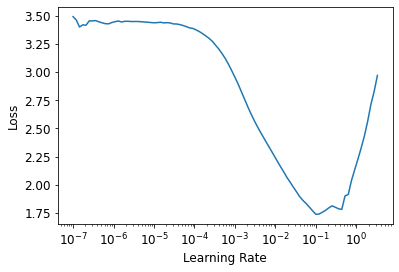

In [131]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.00831763744354248 lrSteep: 0.001737800776027143


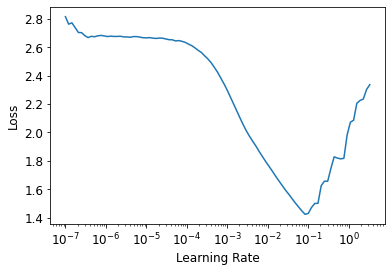

In [132]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

epoch,train_loss,valid_loss,time
0,2.409995,1.837538,00:00
1,1.459110,5.961710,00:00
2,1.036414,4.333563,00:00
3,0.774423,3.518509,00:00
4,0.608193,2.480069,00:00
5,0.492244,1.710064,00:00
6,0.408323,1.112696,00:00
7,0.344567,0.580383,00:00
8,0.296154,0.324168,00:00
9,0.257527,0.145715,00:00


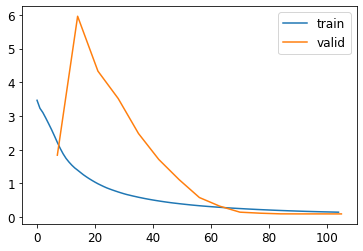

In [133]:
learn_r.fit_one_cycle(15, lr_max=lrMin_r)
learn_r.recorder.plot_loss(skip_start=0)

epoch,train_loss,valid_loss,time
0,1.980098,2.061821,00:00
1,1.266820,2.567309,00:00
2,0.958447,1.692884,00:00
3,0.758073,1.204537,00:00
4,0.626271,0.981654,00:00
5,0.535470,0.870043,00:00
6,0.468649,0.682228,00:00
7,0.417763,0.575129,00:00
8,0.377306,0.441391,00:00
9,0.344776,0.307334,00:00


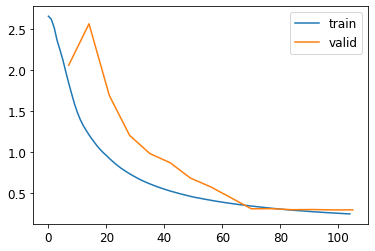

In [134]:
learn_c.fit_one_cycle(15, lr_max=lrMin_c)
learn_c.recorder.plot_loss(skip_start=0)

registered:
lrMin/10: 9.999999747378752e-07 lrSteep: 6.309573450380412e-07


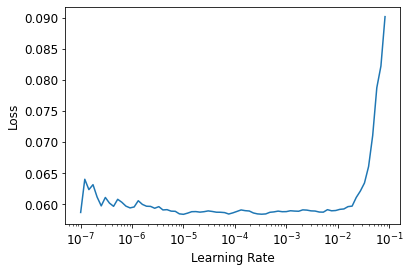

In [135]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.0019054606556892395 lrSteep: 1.0964781722577754e-06


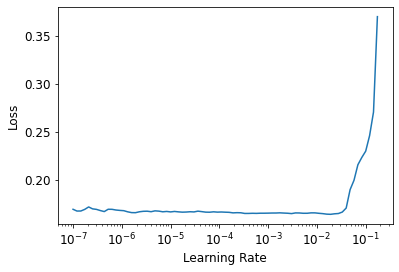

In [136]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

## Ensembling

### Validation Set

The averaging of the scores must be done in the linear state of the count variables.

In [139]:
rfPreds_r = m_r.predict(validXsFinal_r)
rfPreds_c = m_c.predict(validXsFinal_c)

nnPreds_r,nnTargs_r = learn_r.get_preds()
nnPreds_c,nnTargs_c = learn_c.get_preds()

ensPreds_r = np.log( (np.exp(to_np(nnPreds_r.squeeze())) - 1 + np.exp(rfPreds_r) - 1)/2 + 1)
ensPreds_c = np.log( (np.exp(to_np(nnPreds_c.squeeze())) - 1 + np.exp(rfPreds_c) - 1)/2 + 1)

In [140]:
print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.414192
casual final: 0.554685


In [141]:
print('Neural Network Final Results')
print('registered:', r_mse(nnPreds_r, nnTargs_r))
print('casual:    ', r_mse(nnPreds_c, nnTargs_c))

Neural Network Final Results
registered: 0.306327
casual:     0.542662


In [142]:
print('Ensembled RF/NN Final Results')
print('registered:', r_mse(ensPreds_r, validY_r))
print('casaul:    ', r_mse(ensPreds_c, validY_c))

Ensembled RF/NN Final Results
registered: 0.329697
casaul:     0.521442


An important note here is that we're not averaging the errors here, we're averaging the predictions. This is why we can go from `registered` error of 0.414192 and 0.340669 for RF and NN respectively to an ensembled error of 0.33366. 

Now to get the validation error for the total `counts`, to convert my `y_r` and `y_c` into `y_total`.
$$
y_t = \log(e^{y_r} + e^{y_c} - 1)
$$

The `y` values above are `np.log(counts + 1)`.

In [143]:
print('Total count Final Results')
#print('count:', r_mse(ensPreds, y))

y_t = np.log( np.exp(y_r) + np.exp(y_c) - 1 )

y, y_t

Total count Final Results


(0        2.833213
 1        3.713572
 2        3.496508
 3        2.639057
 4        0.693147
            ...   
 10761    5.768321
 10762    5.402678
 10763    5.153292
 10764    4.934474
 10765    4.905275
 Name: count, Length: 8026, dtype: float32,
 0        2.833213
 1        3.713572
 2        3.496508
 3        2.639057
 4        0.693147
            ...   
 10761    5.768321
 10762    5.402677
 10763    5.153291
 10764    4.934474
 10765    4.905275
 Length: 8026, dtype: float32)

The original `y` aka `log(counts + 1)` are the same as `y_t` so this is how we can combine the predictions later. 

## Convert to `counts`

Now need to convert the predictions to an array of `counts`. Do this by exponentiating and then subtracting 1 and then summing the resulting values.

In [144]:
ensPreds = np.log( np.exp(ensPreds_r) + np.exp(ensPreds_c) - 1 )
ensPreds = np.exp(ensPreds) - 1
ensPreds

array([ 22.02203195,  16.51974069,  11.81087413, ..., 187.86072139, 142.55988011, 100.93165329])

Make subroutine to perform the conversion,

In [146]:
def convert_to_counts(log_r, log_c):
    counts = np.exp(log_r) + np.exp(log_c) - 2
    return counts

convert_to_counts(ensPreds_r, ensPreds_c) # test that it returns same as above

array([ 22.02203195,  16.51974069,  11.81087413, ..., 187.86072139, 142.55988011, 100.93165329])

## Predict test set

Do I write the predictions as `count` or as `np.log(count+1)` when submitting to Kaggle? I think `count`.

### Random Forest Predictions

Predicting the test set targets is simple, just use the `.predict()` method,

In [147]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest = convert_to_counts(rfPredsTest_r, rfPredsTest_c)

rfPredsTest

array([  7.84359025,   5.76699757,   3.60837056, ..., 167.32825819, 120.08475867, 106.83885499])

### Neural Network Predictions

Predicting the test set with a NN is more complicated. The original dataframe that the `tabular_learner` is trained on must also contain the test set data, not be trained on the test data but it must contain the data so that the learner knows the cardinality of all columns. Then the `.dls.test_dl()` method can be used along with `.get_preds()` to calculate the predictions for the test set,

In [155]:
dlTest_r = learn_r.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_r,_ = learn_r.get_preds(dl=dlTest_r)

nnPredsTest_r = to_np( nnPredsTest_r.squeeze() )

nnPredsTest_r

array([2.250543 , 1.8384917, 1.3002486, ..., 5.231415 , 4.953573 , 4.561414 ], dtype=float32)

In [156]:
dlTest_c = learn_c.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_c,_ = learn_c.get_preds(dl=dlTest_c)

nnPredsTest_c = to_np( nnPredsTest_c.squeeze() )

nnPredsTest_c

array([0.4903522 , 0.28597403, 0.23954135, ..., 1.5689381 , 1.5163847 , 1.2607172 ], dtype=float32)

In [157]:
nnPredsTest = convert_to_counts(nnPredsTest_r, nnPredsTest_c)
nnPredsTest

array([  9.125782 ,   5.618106 ,   2.9408755, ..., 189.85881  , 144.23605  ,  97.24666  ], dtype=float32)

### Ensemble Test Set Predictions

In [158]:
ensPredsTest = (rfPredsTest + nnPredsTest)/2
ensPredsTest

array([  8.48468613,   5.69255173,   3.27462305, ..., 178.59353431, 132.16040607, 102.04275666])

------

## Create Submission File

Now we have the converted counts for random forest, neural network, and ensembled test set predictions. Recall that we previously saved the test set `datetime` column as `datetimeTest` so let's take a look at that,

### Generate datetime

In [168]:
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

Judging from the sample submission file on the Kaggle page, https://www.kaggle.com/c/bike-sharing-demand/data

The submission format for the prediction rows should be the following:
```
YYYY-MM-DD hh:mm:ss,count
```

with the first three columns (first being the header column) being:
```
datetime,count
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
```

In [174]:
print(datetimeTest[0])
print(datetimeTest[1])

2011-01-20 00:00:00
2011-01-20 01:00:00


Looks like we are good to go with the datetime column.

In [188]:
def write_submission_csv(filename, datetimeCol, predCol):
    f = open(filename, 'w')
    f.write('{},{}\n'.format('datetime', 'count'))
    for i in range(len(datetimeCol)):
        f.write('{},{}\n'.format(datetimeCol[i], predCol[i]))

### Random Forest

In [193]:
write_submission_csv('rf_submit.csv', datetimeTest, rfPredsTest)

!head rf_submit.csv

datetime,count
2011-01-20 00:00:00,7.843590247163867
2011-01-20 01:00:00,5.766997570264679
2011-01-20 02:00:00,3.6083705642241046
2011-01-20 03:00:00,3.1138689718371557
2011-01-20 04:00:00,3.15127979281593
2011-01-20 05:00:00,4.397997510602125
2011-01-20 06:00:00,27.719165174928104
2011-01-20 07:00:00,78.38054711432271
2011-01-20 08:00:00,92.79367292601026


### Neural Network

In [194]:
write_submission_csv('nn_submit.csv', datetimeTest, nnPredsTest)
    
!head nn_submit.csv

datetime,count
2011-01-20 00:00:00,9.125782012939453
2011-01-20 01:00:00,5.618105888366699
2011-01-20 02:00:00,2.94087553024292
2011-01-20 03:00:00,1.9088647365570068
2011-01-20 04:00:00,1.858950138092041
2011-01-20 05:00:00,7.8939008712768555
2011-01-20 06:00:00,34.542118072509766
2011-01-20 07:00:00,98.39105224609375
2011-01-20 08:00:00,192.9104461669922


### Ensemble

In [195]:
write_submission_csv('ens_submit.csv', datetimeTest, ensPredsTest)
    
!head ens_submit.csv

datetime,count
2011-01-20 00:00:00,8.48468613005166
2011-01-20 01:00:00,5.692551729315689
2011-01-20 02:00:00,3.2746230472335123
2011-01-20 03:00:00,2.5113668541970813
2011-01-20 04:00:00,2.5051149654539855
2011-01-20 05:00:00,6.14594919093949
2011-01-20 06:00:00,31.130641623718937
2011-01-20 07:00:00,88.38579968020824
2011-01-20 08:00:00,142.8520595465012
